# Funnel Analysis

In [1]:
%matplotlib inline
#^^^ =inline for jupyterlab; =notebook for jupyter notebook
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML, display
from datetime import datetime, date, time, timedelta
from pandas import Series, DataFrame
matplotlib.style.use('ggplot')

In [7]:
dateparser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
#TODO: add dtype={"deviceid":np.intxx} instead of low_memory. currently, it is guessing dtype
#      only after everything is loaded into memory
df = pd.read_csv('events.csv', encoding="utf-16", low_memory = False, 
                 parse_dates=['date'], 
                 date_format={'date':'%Y-%m-%d %H:%M:%S'}
                )
# let us print how many records are we talking about here
df.shape

(5940, 3)

In [8]:
# make a new data frame to filter events for last 10 hours only
dft = df[df["date"]>=datetime.now() - timedelta(hours=10)]
#dft = dft[dft["date"] <= datetime.now() - timedelta(hours=3)] #to further filter down between t-10 and t-3 hours
dft.shape

(5652, 3)

## Group data into a funnel by deviceid
Now, let us group the data frame into another funnel.

We will only take those devices that had First Launch count as 1 to ignore all the upgrade after install before situations.

In [9]:
GROUP_KEY = 'deviceid'
TIME_FIELD = 'date'
EVENT_FIELD = 'event'
FUNNEL_STEPS = [
    'First Launch', 
    'Register Button', 
    'Provide Email', 
    'Validate Email', 
    'Terms & Conditions Show', 
    'Terms & Conditions Accept'
    ]


def funnelize_by_timestamp(group, funnel_steps):
    curr = 0
    funnel_cts = [0 for s in funnel_steps]

    for i, row in group.iterrows():
        evt = row[EVENT_FIELD]
        if evt in funnel_steps:
            idx = funnel_steps.index(evt)
            if idx <= curr + 1:
                funnel_cts[idx] += 1
                curr = idx
    return funnel_cts
    

def funnelize_wo_timestamp(group, funnel_steps):
    funnel_cts = [0 for s in funnel_steps]

    for i, row in group.iterrows():
        evt = row[EVENT_FIELD]
        if evt in funnel_steps:
            idx = funnel_steps.index(evt)
            funnel_cts[idx] += 1
    return funnel_cts

def mkfunnel(pddf):
    # sort event dataset by time - this is only required because
    # of the code above in funnelize to consider counts for a group
    # and event, provided previous event was hit
    pddf.sort_values(by=TIME_FIELD, ascending=True, inplace=True)

    # step through events by group_key 
    # and increment event counts by funnel step if prior funnel steps occurred
    funnel_cts = pddf.groupby(GROUP_KEY).apply(funnelize_wo_timestamp, FUNNEL_STEPS)

    # format results as a dataframe
    funnel = pd.DataFrame(list(funnel_cts.values), index=funnel_cts.index, columns=FUNNEL_STEPS)
    #filter and make a new df that has first launch already

    funnel = funnel[funnel['First Launch']==1]
    
    return funnel

funnel = mkfunnel(dft.copy())
funnel.shape


(1402, 6)

We got so many devices in the funnel, that has done *First Launch*.

Now, let us reduce the counts for each event to just having it as a normalized. For example, if a device has had *Register Button* 5 times, let us have another funnel that just has this as 1. This way, we can easily dedupe the event count.

In [10]:
# funnel summary, deduped across group key 
# (i.e., event occurrences become 1/0 indicators instead of counts)
funnel_norm = funnel.copy()
funnel_norm[funnel_norm != 0] = 1

top_of_funnel = funnel_norm[FUNNEL_STEPS[0]].sum()
latest_step_count = top_of_funnel
htmltbl = [['<b>Event</b>', '<b>Devices</b>', '<b>% / ' + FUNNEL_STEPS[0] + '</b>', '<b>% / Prev Step</b>']]
for fs in FUNNEL_STEPS:
    fs_devices = funnel_norm[fs].sum()
    htmltbl.append([fs, fs_devices, round(100-100.0*fs_devices/top_of_funnel,2), round(100-100.0*fs_devices/latest_step_count,2)])
    latest_step_count = fs_devices

display(HTML(
    '<h4>Drop Off Funnel</h4><table><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in htmltbl)
        )
))


Event,Devices,% / First Launch,% / Prev Step
First Launch,1402,0.0,0.0
Register Button,1168,16.69,16.69
Provide Email,930,33.67,20.38
Validate Email,710,49.36,23.66
Terms & Conditions Show,477,65.98,32.82
Terms & Conditions Accept,255,81.81,46.54


<Axes: >

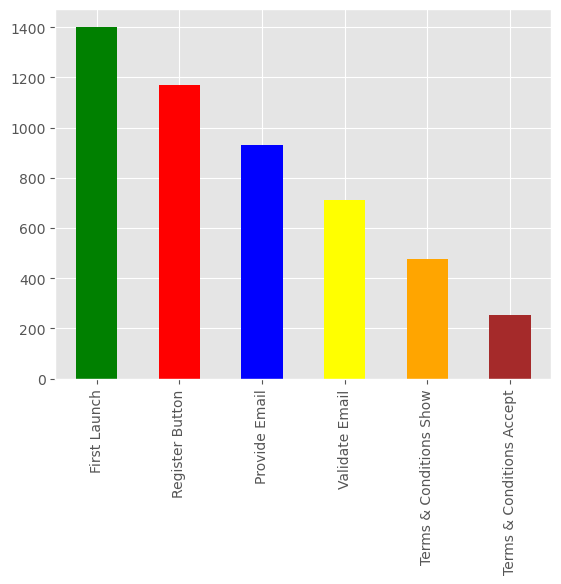

In [11]:
# plot the bar chart. color is an optional list of bar colors - it will cycle if you've fewer colors than data 
funnel_norm[FUNNEL_STEPS].sum().plot.bar(color=['green','red','blue','yellow','orange', 'brown'])